## Comparison: FiMDP vs STORM

In [53]:
import fimdp
import fimdpenv
import fimdpenv.UUVEnv as UUVEnv
fimdpenv.setup()
import stormpy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fimdp import io as fi2st
from fimdp.objectives import AS_REACH, BUCHI
from fimdp.energy_solvers import BasicES

This notebook compares the performance of FiMDP with Storm, anopen-source, state-of-the-art probablistic model checker designed to be efficient in terms of time and memory. We use instances of the UUV Environment to perform experiments. All computations presented below were performed on a PC with Intel Core i7-8700 3.20GHz 12 core processor and a RAM of 16 GB running Ubuntu 18.04 LTS. We start with defining some functions to help us perform the comparison.

In [9]:
def buchi_storm(storm_mdp):
    formula = 'Pmax>=1 [G Pmax>=1 [F "target" & Pmax>=1 [F "reload"]]]'
    prop = stormpy.parse_properties(formula)
    
    return stormpy.model_checking(storm_mdp, prop[0])

In [10]:
def buchi_fimdp(mdp, capacity, targets):
    solver = BasicES(mdp, capacity, targets)
    fimdp_res = solver.compute(BUCHI)

In [11]:
def create_gw(size, capacity):

    constants = {
        "size_x" : size,
        "size_y" : size,
        "capacity" : capacity,
        "cons_w_ex" : 0,
        "cons_s_ex" : 0,
        "targets" : [13,2],
        "reloads" : [15,3],
    }

    env = UUVEnv.SingleAgentEnv([constants["size_x"], constants["size_y"]], constants["capacity"], constants["targets"], constants["reloads"])
    return env.consmdp, set(constants["targets"])

In [12]:
def benchmark_on_gw(size_range, cap_range):
    df = pd.DataFrame(columns=["size", "capacity", "cmdp_size", "mdp_size", "fimdp_time", "storm_time"])

    for size in size_range:
        for capacity in cap_range:
            cap = int(capacity*size)
            print(f"size={size} and capacity={cap}")
            res = {
                "size": size,
                "capacity": cap,
            }

            mdp, targets = create_gw(size, cap)
            res["cmdp_size"] = mdp.num_states

            st_mdp = fi2st.encode_to_stormpy(mdp, cap, targets)
            res["mdp_size"] = st_mdp.nr_states

            fimdp_time = %timeit -o -q buchi_fimdp(mdp, cap, targets)
            res["fimdp_time"] = fimdp_time.average
            storm_time = %timeit -o -q buchi_storm(st_mdp)
            res["storm_time"] = storm_time.average

            df = df.append(res, ignore_index=True)
    return df

### Generate and store comparison data

In [ ]:
# generate results for various grid sizes and energies
results = {}
results["gs10"] = benchmark_on_gw([10], [1,2,3,5,10])
results["gs20"] = benchmark_on_gw([20], [1,2,3,5,10])
results["gs50"] = benchmark_on_gw([50], [1,2,3,5,10])

In [12]:
# store the data as csv files
for k, v in results.items():
    v.to_csv('./data/{}_timedata.csv'.format(k))

We measure the time FiMDP needs to analyze such CMDPs and to synthesize the corresponding strategy for the
given Büchi objective. We also transform the CMDP into the equivalent MDP with the energy constraints encoded in states and actions. We then measure the time that Stormpy needs to finish stormpy.model checking(mdp, prop) for
this MDP and the qualitative Büchi property expressed in PCTL [1] as: prop = ’Pmax>=1 [G Pmax>=1 [F "target" & Pmax>=1 [F "reload"]]]’. 

We perform experiments for different grid sizes and energy levels in the UUV environment. The results from the experiment are shown below.

### Load and plot comparison data

In [37]:
# load the data
df_gs10 = pd.read_csv('./data/gs10_timedata.csv')
df_gs20 = pd.read_csv('./data/gs20_timedata.csv')
df_gs50 = pd.read_csv('./data/gs50_timedata.csv')

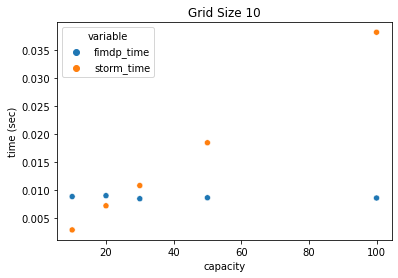

In [69]:
# plot grid-size 10 data
df = df_gs10.melt(id_vars=['capacity'], value_vars=['fimdp_time', 'storm_time'])
sns.scatterplot(x='capacity', y='value', hue='variable', data=df)
plt.ylabel('time (sec)')
plt.title('Grid Size 10')
plt.show()

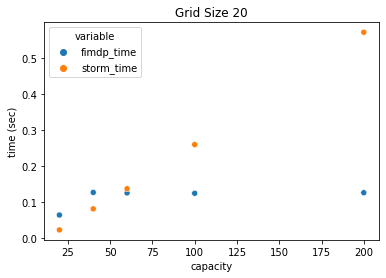

In [70]:
#plto grid-size 20 data
df = df_gs20.melt(id_vars=['capacity'], value_vars=['fimdp_time', 'storm_time'])
sns.scatterplot(x='capacity', y='value', hue='variable', data=df)
plt.ylabel('time (sec)')
plt.title('Grid Size 20')
plt.show()

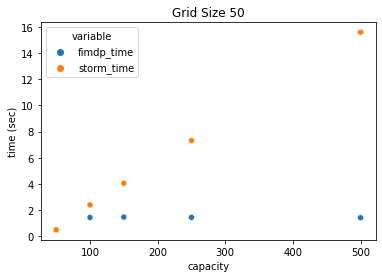

In [72]:
# plot grid-size 50 data
df = df_gs50.melt(id_vars=['capacity'], value_vars=['fimdp_time', 'storm_time'])
sns.scatterplot(x='capacity', y='value', hue='variable', data=df)
plt.ylabel('time (sec)')
plt.title('Grid Size 50')
plt.show()